# Параллельные вычисления

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. Лекция "Параллельные вычисления"
* https://docs.python.org/3/library/multiprocessing.html
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Process
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Queue
* https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
* https://numpy.org/doc/stable/reference/generated/numpy.array_split.html
* https://nalepae.github.io/pandarallel/
    * https://github.com/nalepae/pandarallel/blob/master/docs/examples_windows.ipynb
    * https://github.com/nalepae/pandarallel/blob/master/docs/examples_mac_linux.ipynb

## Задачи для совместного разбора

In [1]:
# !pip install pandarallel

1. Посчитайте, сколько раз встречается буква "a" в файлах ["xaa", "xab", "xac", "xad"]. 

In [7]:
%%time
import multiprocessing
def count_as(s):
    with open(s, 'r') as file:
        text = file.read()
        return text.count('a')
    

files = [f"{name}.txt" for name in ["xaa", "xab", "xac", "xad"]]
with(multiprocessing.Pool(processes=len(files))) as p:
    res = p.map(count_as, files)
    print(sum(res))

8998272
CPU times: user 3.99 ms, sys: 9.94 ms, total: 13.9 ms
Wall time: 106 ms


2. Выведите на экран слова из файла words_alpha, в которых есть две или более буквы "e" подряд.

In [9]:
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
def decide(word):
    previous_letter = 'a'
    for i in word:
        if i=='e' and previous_letter=='e':
            return True
        previous_letter = i
    return False
words = (
    pd.read_csv("words_alpha.txt", header=None)[0]
    .dropna()
    .sample(frac=1, replace=True)
)
words[words.parallel_apply(decide)]


INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


219609          overgreedy
264613            reelable
264732           reengrave
283159             seeping
264779       reenumerating
                ...       
322206        thirteenfold
247194    preeducationally
162307            jumpseed
264752        reenlightens
163567            keelsons
Name: 0, Length: 7223, dtype: object

## Лабораторная работа 10

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy` и `pandas`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy` или структур `pandas` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

1\. В каждой строке файла `tag_nsteps.csv` хранится информация о тэге рецепта и количестве шагов в этом рецепте в следующем виде:

```
tags,n_steps
hungarian,2
european,6
occasion,4
pumpkin,4
................
```

Всего в исходном файле хранится чуть меньше, чем 71 млн, строк. Разбейте файл `tag_nsteps.csv` на несколько (например, 8) примерно одинаковых по объему файлов c названиями `tag_nsteps_*.csv`, где вместо символа `*` указан номер очередного файла. Каждый файл имеет структуру, аналогичную оригинальному файлу (включая заголовок).

__Важно__: здесь и далее вы не можете загружать в память весь исходный файл сразу. 

In [10]:
def split_file(part):
    number = int(part.index[0]/chunksize)
    with open(f'tag_nsteps_{number}.csv', 'w') as file:
        part.to_csv(file)
chunksize = 71*10**6/8
with pd.read_csv('tag_nsteps.csv', chunksize=chunksize) as file:
    with multiprocessing.Pool(processes=8) as p:
        p.map(split_file, [i for i in file])

2\. Напишите функцию, которая принимает на вход название файла, созданного в результате решения задачи 1, считает для каждого тэга сумму по столбцу `n_steps` и количество строк c этим тэгом, и возвращает результат в виде словаря. Ожидаемый вид итогового словаря:

```
{
    '1-day-or-more': {'sum': 56616, 'count': 12752},
    '15-minutes-or-less': {'sum': 195413, 'count': 38898},
    '3-steps-or-less': {'sum': 187938, 'count': 39711},
    ....
}
```

Примените данную функцию к каждому файлу, полученному в задании 1, и соберите результат в виде списка словарей. Не используйте параллельных вычислений. 

Выведите на экран значение по ключу "30-minutes-or-less" для каждого из словарей.

In [11]:
def get_tag_sum_count_from_file(file: str) -> dict:
    file = pd.read_csv(file)
    a = file.groupby('tags').n_steps.sum()
    b = file.groupby('tags').n_steps.count()
    df = pd.DataFrame(a)
    df = df.rename(columns = {'n_steps':'sum'})
    df['count'] = b
    return {i[0]:{'sum':i[1]['sum'], 'count': i[1]['count']} for i in df.iterrows()}

In [12]:
lst = list(map(get_tag_sum_count_from_file, [f'tag_nsteps_{i}.csv' for i in range(8)]))

In [36]:
lst

[{'1-day-or-more': {'sum': 56616, 'count': 12752},
  '15-minutes-or-less': {'sum': 195413, 'count': 38898},
  '3-steps-or-less': {'sum': 187938, 'count': 39711},
  '30-minutes-or-less': {'sum': 348943, 'count': 45605},
  '4-hours-or-less': {'sum': 429827, 'count': 42683},
  '5-ingredients-or-less': {'sum': 179724, 'count': 33842},
  '60-minutes-or-less': {'sum': 522209, 'count': 55224},
  'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.': {'sum': 39985,
   'count': 11451},
  'a1-sauce': {'sum': 40025, 'count': 11357},
  'african': {'sum': 57174, 'count': 13138},
  'american': {'sum': 232336, 'count': 30755},
  'amish-mennonite': {'sum': 40700, 'count': 11419},
  'angolan': {'sum': 39530, 'count': 11285},
  'appetizers': {'sum': 150075, 'count': 24009},
  'apples': {'sum': 69464, 'count': 14320},
  'april-fools-day': {'sum': 39256, 'count': 11228},
  'argentine': {'sum': 40794, 'count': 11393},
  'artichoke': {'sum': 40371, 'count': 11546},
  'asian': {'sum': 12767

In [13]:
[i['30-minutes-or-less'] for i in lst]

[{'sum': 348943, 'count': 45605},
 {'sum': 350194, 'count': 46053},
 {'sum': 353624, 'count': 46295},
 {'sum': 347697, 'count': 45621},
 {'sum': 346528, 'count': 45650},
 {'sum': 350333, 'count': 46014},
 {'sum': 346536, 'count': 45814},
 {'sum': 339350, 'count': 44730}]

3\. Напишите функцию, которая объединяет результаты обработки отдельных файлов. Данная функция принимает на вход список словарей, каждый из которых является результатом вызова функции `get_tag_sum_count_from_file` для конкретного файла, и агрегирует эти словари. Не используйте параллельных вычислений.

Процедура агрегации словарей имеет следующий вид:
$$d_{agg}[k] = \{sum: \sum_{i=1}^{n}d_{i}[k][sum], count: \sum_{i=1}^{n}d_{i}[k][count]\}$$
где $d_1, d_2, ..., d_n$- результат вызова функции `get_tag_sum_count_from_file` для конкретных файлов.

Примените данную функцию к результату выполнения задания 2. Выведите на экран результат для тэга "30-minutes-or-less".

In [14]:
sum([i[j]['sum'] for i in lst for j in i])

373128974

In [18]:
st = set([j for i in lst for j in i])

def agg_results(tag_sum_count_list: list) -> dict:
    return {tag:{'sum': sum([i for i in[i[tag]['sum'] for i in tag_sum_count_list]]), 'count':sum([i for i in[i[tag]['count'] for i in tag_sum_count_list]])} for tag in st}

In [19]:
agg_results(lst)["30-minutes-or-less"]

{'sum': 2783205, 'count': 365782}

In [41]:
agg = agg_results(lst)
agg

{'hungarian': {'sum': 333741, 'count': 90956},
 'weeknight': {'sum': 1457050, 'count': 196463},
 'low-saturated-fat': {'sum': 1613001, 'count': 247338},
 'steam': {'sum': 342786, 'count': 93003},
 'vegan': {'sum': 731389, 'count': 140439},
 'microwave': {'sum': 414103, 'count': 101418},
 'plums': {'sum': 324716, 'count': 90988},
 'scandinavian': {'sum': 379927, 'count': 96368},
 'smoothies': {'sum': 347864, 'count': 99457},
 'meat': {'sum': 3305780, 'count': 370656},
 'beef-sauces': {'sum': 320068, 'count': 91232},
 'lamb-sheep': {'sum': 405043, 'count': 98340},
 'beef-organ-meats': {'sum': 321206, 'count': 90399},
 'pork-loins-roast': {'sum': 316585, 'count': 90047},
 'berries': {'sum': 598580, 'count': 120105},
 'austrian': {'sum': 324056, 'count': 90754},
 'beijing': {'sum': 319322, 'count': 91035},
 'potluck': {'sum': 822609, 'count': 143227},
 'deep-fry': {'sum': 384618, 'count': 95800},
 'pressure-cooker': {'sum': 340552, 'count': 93006},
 'tomatoes': {'sum': 583759, 'count': 120

4\. Напишите функцию, которая считает среднее значение количества шагов для каждого тэга в словаре, имеющего вид, аналогичный словарям в задаче 2, и возвращает результат в виде словаря . Используйте решения задач 1-3, чтобы получить среднее значение количества шагов каждого тэга для всего датасета, имея результаты обработки частей датасета и результат их агрегации. Выведите на экран результат для тэга "30-minutes-or-less".

Определите, за какое время задача решается для всего датасета. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [21]:
def get_tag_mean_n_steps(tag_sum_count: dict) -> dict:
    return {i:tag_sum_count[i]['sum']/tag_sum_count[i]['count'] for i in tag_sum_count}

In [22]:
get_tag_mean_n_steps(agg)["30-minutes-or-less"]

7.608917333275011

In [23]:
%%time
lst = list(map(get_tag_sum_count_from_file, [f'tag_nsteps_{i}.csv' for i in range(8)]))
agg = agg_results(lst)
get_tag_mean_n_steps(agg)

CPU times: user 18.2 s, sys: 1.3 s, total: 19.5 s
Wall time: 19.5 s


{'biscotti': 3.7436879340559486,
 'served-cold': 4.907176572135087,
 'muffins': 4.305987141709081,
 'corn': 4.076354728074473,
 'south-american': 3.931873077478891,
 'blueberries': 3.965573486385369,
 'english': 4.172752723510437,
 'portuguese': 3.6397163272063144,
 'chocolate-chip-cookies': 3.5171703221422073,
 'pitted-fruit': 4.11792971865252,
 'nut-free': 3.5797187797902765,
 'cobblers-and-crisps': 3.9075219798111362,
 'beef': 6.946412491292454,
 'reynolds-wrap': 3.570161916319547,
 'southern-united-states': 5.248305091372583,
 'hand-formed-cookies': 4.257923176556302,
 'chicken-stews': 3.5085177554772824,
 'danish': 3.5798978038704066,
 'brown-bag': 4.355027864822772,
 'rice': 5.102978597251159,
 'condiments-etc': 4.775308379413016,
 'cheesecake': 4.4482271246850615,
 'artichoke': 3.497125083509479,
 'frozen-desserts': 4.037689705838847,
 'coffee-cakes': 4.045286125977769,
 'filipino': 3.5699659819442626,
 'micro-melanesia': 3.511589750366137,
 'spring': 4.5469235213403625,
 'costa

5\. Повторите решение задачи 4, распараллелив вызовы функции `get_tag_sum_count_from_file` для различных файлов с помощью `multiprocessing.Pool`. Для обработки каждого файла создайте свой собственный процесс. Выведите на экран результат для тэга "30-minutes-or-less". Определите, за какое время задача решается для всех файлов. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [24]:
def everything(num):
    return get_tag_sum_count_from_file(f'tag_nsteps_{num}.csv')

In [25]:
%%time
with multiprocessing.Pool(processes=8) as p:
    l = list(p.map(get_tag_sum_count_from_file, [f'tag_nsteps_{i}.csv' for i in range(8)]))
agg = agg_results(l)
get_tag_mean_n_steps(agg)

CPU times: user 19.6 ms, sys: 24.1 ms, total: 43.7 ms
Wall time: 4.09 s


{'biscotti': 3.7436879340559486,
 'served-cold': 4.907176572135087,
 'muffins': 4.305987141709081,
 'corn': 4.076354728074473,
 'south-american': 3.931873077478891,
 'blueberries': 3.965573486385369,
 'english': 4.172752723510437,
 'portuguese': 3.6397163272063144,
 'chocolate-chip-cookies': 3.5171703221422073,
 'pitted-fruit': 4.11792971865252,
 'nut-free': 3.5797187797902765,
 'cobblers-and-crisps': 3.9075219798111362,
 'beef': 6.946412491292454,
 'reynolds-wrap': 3.570161916319547,
 'southern-united-states': 5.248305091372583,
 'hand-formed-cookies': 4.257923176556302,
 'chicken-stews': 3.5085177554772824,
 'danish': 3.5798978038704066,
 'brown-bag': 4.355027864822772,
 'rice': 5.102978597251159,
 'condiments-etc': 4.775308379413016,
 'cheesecake': 4.4482271246850615,
 'artichoke': 3.497125083509479,
 'frozen-desserts': 4.037689705838847,
 'coffee-cakes': 4.045286125977769,
 'filipino': 3.5699659819442626,
 'micro-melanesia': 3.511589750366137,
 'spring': 4.5469235213403625,
 'costa

6\. Повторите решение задачи 4, распараллелив вычисления функции `get_tag_sum_count_from_file` для различных файлов с помощью `multiprocessing.Process`. Для обработки каждого файла создайте свой собственный процесс. Для обмена данными между процессами используйте `multiprocessing.Queue`.

Выведите на экран результат для тэга "30-minutes-or-less". Определите, за какое время задача решается для всех файлов. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [27]:
%%time
def work(i):
    multiprocessing.Process(target=worker, args=(task_queue, done_queue)).start()
def worker(input, output):
    output.put(get_tag_sum_count_from_file(f'tag_nsteps_{input.get()}.csv'))
task_queue = multiprocessing.Queue()
done_queue = multiprocessing.Queue()
put = lambda x: task_queue.put(x)
list(map(put, range(8)))
list(map(work, range(8)))
agg = agg_results([done_queue.get() for i in range(8)])
mean = get_tag_mean_n_steps(agg)

CPU times: user 13.9 ms, sys: 44 ms, total: 57.9 ms
Wall time: 3.9 s


In [28]:
mean["30-minutes-or-less"]

7.608917333275011

7\. Исследуйте, как влияет количество запущенных одновременно процессов на скорость решения задачи. Узнайте количество ядер вашего процессора $K$. Повторите решение задачи 1, разбив исходный файл на $\frac{K}{2}$, $K$ и $2K$ фрагментов. Для каждого из разбиений повторите решение задачи 5. Визуализируйте зависимость времени выполнения кода от количества файлов в разбиении. Сделайте вывод в виде текстового комментария.

In [30]:
def split_file6(part):
    number = int(part.index[0]/chunksize)
    with open(f'tag_nsteps_6_{number}.csv', 'w') as file:
        part.to_csv(file)
chunksize = int(71*10**6/6)
with pd.read_csv('tag_nsteps.csv', chunksize=chunksize) as file:
    with multiprocessing.Pool(processes=6) as p:
        p.map(split_file6, [i for i in file])

In [31]:
%%time
with multiprocessing.Pool(processes=6) as p:
    l = list(p.map(get_tag_sum_count_from_file, [f'tag_nsteps_6_{i}.csv' for i in range(6)]))
agg = agg_results(l)
get_tag_mean_n_steps(agg)

CPU times: user 17.3 ms, sys: 18.2 ms, total: 35.5 ms
Wall time: 4.55 s


{'biscotti': 3.7436879340559486,
 'served-cold': 4.907176572135087,
 'muffins': 4.305987141709081,
 'corn': 4.076354728074473,
 'south-american': 3.931873077478891,
 'blueberries': 3.965573486385369,
 'english': 4.172752723510437,
 'portuguese': 3.6397163272063144,
 'chocolate-chip-cookies': 3.5171703221422073,
 'pitted-fruit': 4.11792971865252,
 'nut-free': 3.5797187797902765,
 'cobblers-and-crisps': 3.9075219798111362,
 'beef': 6.946412491292454,
 'reynolds-wrap': 3.570161916319547,
 'southern-united-states': 5.248305091372583,
 'hand-formed-cookies': 4.257923176556302,
 'chicken-stews': 3.5085177554772824,
 'danish': 3.5798978038704066,
 'brown-bag': 4.355027864822772,
 'rice': 5.102978597251159,
 'condiments-etc': 4.775308379413016,
 'cheesecake': 4.4482271246850615,
 'artichoke': 3.497125083509479,
 'frozen-desserts': 4.037689705838847,
 'coffee-cakes': 4.045286125977769,
 'filipino': 3.5699659819442626,
 'micro-melanesia': 3.511589750366137,
 'spring': 4.5469235213403625,
 'costa

In [32]:
def split_file12(part):
    number = int(part.index[0]/chunksize)
    with open(f'tag_nsteps_12_{number}.csv', 'w') as file:
        part.to_csv(file)
chunksize = int(71*10**6/12)
with pd.read_csv('tag_nsteps.csv', chunksize=chunksize) as file:
    with multiprocessing.Pool(processes=12) as p:
        p.map(split_file12, [i for i in file])

In [33]:
%%time
with multiprocessing.Pool(processes=12) as p:
    l = list(p.map(get_tag_sum_count_from_file, [f'tag_nsteps_12_{i}.csv' for i in range(12)]))
agg = agg_results(l)
get_tag_mean_n_steps(agg)

CPU times: user 47.6 ms, sys: 52.8 ms, total: 100 ms
Wall time: 4.01 s


{'biscotti': 3.7436879340559486,
 'served-cold': 4.907176572135087,
 'muffins': 4.305987141709081,
 'corn': 4.076354728074473,
 'south-american': 3.931873077478891,
 'blueberries': 3.965573486385369,
 'english': 4.172752723510437,
 'portuguese': 3.6397163272063144,
 'chocolate-chip-cookies': 3.5171703221422073,
 'pitted-fruit': 4.11792971865252,
 'nut-free': 3.5797187797902765,
 'cobblers-and-crisps': 3.9075219798111362,
 'beef': 6.946412491292454,
 'reynolds-wrap': 3.570161916319547,
 'southern-united-states': 5.248305091372583,
 'hand-formed-cookies': 4.257923176556302,
 'chicken-stews': 3.5085177554772824,
 'danish': 3.5798978038704066,
 'brown-bag': 4.355027864822772,
 'rice': 5.102978597251159,
 'condiments-etc': 4.775308379413016,
 'cheesecake': 4.4482271246850615,
 'artichoke': 3.497125083509479,
 'frozen-desserts': 4.037689705838847,
 'coffee-cakes': 4.045286125977769,
 'filipino': 3.5699659819442626,
 'micro-melanesia': 3.511589750366137,
 'spring': 4.5469235213403625,
 'costa

In [34]:
def split_file24(part):
    number = int(part.index[0]/chunksize)
    with open(f'tag_nsteps_24_{number}.csv', 'w') as file:
        part.to_csv(file)
chunksize = int(71*10**6/24)
with pd.read_csv('tag_nsteps.csv', chunksize=chunksize) as file:
    with multiprocessing.Pool(processes=24) as p:
        p.map(split_file24, [i for i in file])

In [35]:
%%time
with multiprocessing.Pool(processes=24) as p:
    l = list(p.map(get_tag_sum_count_from_file, [f'tag_nsteps_24_{i}.csv' for i in range(24)]))
agg = agg_results(l)
get_tag_mean_n_steps(agg)

CPU times: user 71.1 ms, sys: 110 ms, total: 181 ms
Wall time: 3.87 s


{'biscotti': 3.7436879340559486,
 'served-cold': 4.907176572135087,
 'muffins': 4.305987141709081,
 'corn': 4.076354728074473,
 'south-american': 3.931873077478891,
 'blueberries': 3.965573486385369,
 'english': 4.172752723510437,
 'portuguese': 3.6397163272063144,
 'chocolate-chip-cookies': 3.5171703221422073,
 'pitted-fruit': 4.11792971865252,
 'nut-free': 3.5797187797902765,
 'cobblers-and-crisps': 3.9075219798111362,
 'beef': 6.946412491292454,
 'reynolds-wrap': 3.570161916319547,
 'southern-united-states': 5.248305091372583,
 'hand-formed-cookies': 4.257923176556302,
 'chicken-stews': 3.5085177554772824,
 'danish': 3.5798978038704066,
 'brown-bag': 4.355027864822772,
 'rice': 5.102978597251159,
 'condiments-etc': 4.775308379413016,
 'cheesecake': 4.4482271246850615,
 'artichoke': 3.497125083509479,
 'frozen-desserts': 4.037689705838847,
 'coffee-cakes': 4.045286125977769,
 'filipino': 3.5699659819442626,
 'micro-melanesia': 3.511589750366137,
 'spring': 4.5469235213403625,
 'costa

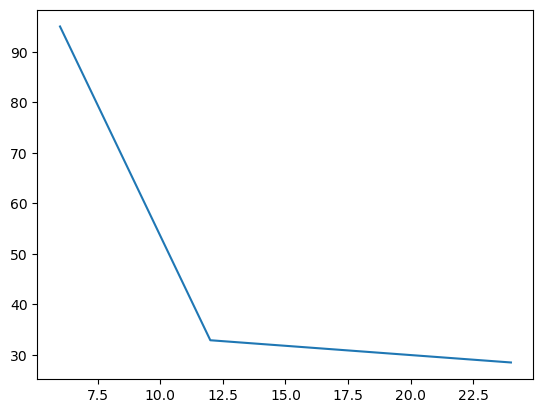

In [36]:
from matplotlib import pyplot as plt
plt.plot([6,12,24], [95, 32.9, 28.5])

Вывод K*2 наиболее эффективно

8\. Напишите функцию `parallel_map`, которая принимает на вход серию `s` `pd.Series` и функцию одного аргумента `f` и поэлементно применяет эту функцию к серии, распараллелив вычисления при помощи пакета `multiprocessing`. Логика работы функции `parallel_map` должна включать следующие действия:
* разбиение исходной серии на $K$ частей, где $K$ - количество ядер вашего процессора;
* параллельное применение функции `f` к каждой части при помощи метода _серии_ `map` при помощи нескольких подпроцессов;
* объединение результатов работы подпроцессов в одну серию. 

In [39]:
K = 12
ser = pd.Series(range(24))
ser

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
dtype: int64

In [40]:
%%time
from numpy import array_split
def parallel_map(s: pd.Series, f: callable) -> pd.Series:
    global smap
    def smap(x):
        return x.map(f)
        #return x*2
    lst = array_split(s, K)
    with multiprocessing.Pool(processes=K) as p:
        return pd.concat(p.map(smap, array_split(s, K)))

CPU times: user 12 µs, sys: 1 µs, total: 13 µs
Wall time: 15.3 µs


In [41]:
parallel_map(ser, lambda x: x**2)

0       0
1       1
2       4
3       9
4      16
5      25
6      36
7      49
8      64
9      81
10    100
11    121
12    144
13    169
14    196
15    225
16    256
17    289
18    324
19    361
20    400
21    441
22    484
23    529
dtype: int64

9\. Напишите функцию `f`, которая принимает на вход тэг и проверяет, удовлетворяет ли тэг следующему шаблону: `[любое число]-[любое слово]-or-less`. Возьмите любой фрагмент файла, полученный в задании 1, примените функцию `f` при помощи `parallel_map` к столбцу `tags` и посчитайте количество тэгов, подходящих под этот шаблон. Решите ту же задачу, воспользовавшись методом _серий_ `map`. Сравните время и результат выполнения двух решений.

In [42]:
import re

In [43]:
def f(tag: str) -> bool:
    if re.match("\d+-\w+-or-less", str(tag)):
        return True
    else:
        return False

In [45]:
df = pd.read_csv('tag_nsteps_0.csv').drop(columns=['Unnamed: 0'])

%%time
len(df.tags[df.tags.map(f)])

CPU times: user 4.97 s, sys: 39.7 ms, total: 5.01 s
Wall time: 5.02 s


255963

In [46]:
%%time
len(df.tags[parallel_map(df.tags, f)])

CPU times: user 419 ms, sys: 160 ms, total: 579 ms
Wall time: 1.35 s


255963

In [47]:
lst[0]

{'1-day-or-more': {'sum': 56616, 'count': 12752},
 '15-minutes-or-less': {'sum': 195413, 'count': 38898},
 '3-steps-or-less': {'sum': 187938, 'count': 39711},
 '30-minutes-or-less': {'sum': 348943, 'count': 45605},
 '4-hours-or-less': {'sum': 429827, 'count': 42683},
 '5-ingredients-or-less': {'sum': 179724, 'count': 33842},
 '60-minutes-or-less': {'sum': 522209, 'count': 55224},
 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.': {'sum': 39985,
  'count': 11451},
 'a1-sauce': {'sum': 40025, 'count': 11357},
 'african': {'sum': 57174, 'count': 13138},
 'american': {'sum': 232336, 'count': 30755},
 'amish-mennonite': {'sum': 40700, 'count': 11419},
 'angolan': {'sum': 39530, 'count': 11285},
 'appetizers': {'sum': 150075, 'count': 24009},
 'apples': {'sum': 69464, 'count': 14320},
 'april-fools-day': {'sum': 39256, 'count': 11228},
 'argentine': {'sum': 40794, 'count': 11393},
 'artichoke': {'sum': 40371, 'count': 11546},
 'asian': {'sum': 127677, 'count': 19833},


10\. Используя пакет `pandarallel`, примените функцию `f` из задания 9 к столбцу `tags` таблицы, с которой вы работали этом задании. Посчитайте количество тэгов, подходящих под описанный шаблон. Измерьте время выполнения кода. Выведите на экран полученный результат.

In [48]:
%%time
len(df.tags[df.tags.parallel_map(f)])

CPU times: user 334 ms, sys: 73.9 ms, total: 408 ms
Wall time: 1.68 s


255963